<a href="https://colab.research.google.com/github/shubhika1723/shubhika_INFO5731_Spring2020/blob/main/In_class_exercise_04_11032022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 11/03/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df = pd.read_csv("Tweets.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

df["Text"] = df["Text"].apply(cleantext)

# Convert to list
data = df.Text.values.tolist()

In [17]:
#Converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['optimistic', 'ability', 'prevent', 'next', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [22]:
# To see what word a given id corresponds to, pass the id as a key to the dictionary
id2word[0]

'ability'

In [23]:
# Or, you can see a human-readable form of the corpus itself.
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"work" + 0.041*"world" + 0.026*"talk" + 0.025*"time" + '
  '0.024*"inspire" + 0.023*"make" + 0.023*"health" + 0.022*"young" + '
  '0.020*"improve" + 0.019*"thank"'),
 (1,
  '0.046*"great" + 0.041*"learn" + 0.024*"thing" + 0.024*"even" + '
  '0.019*"thank" + 0.017*"fight" + 0.017*"breakthrough" + 0.016*"problem" + '
  '0.016*"science" + 0.015*"team"'),
 (2,
  '0.039*"fight" + 0.039*"disease" + 0.037*"day" + 0.030*"ever" + '
  '0.029*"leadership" + 0.027*"alzheimer" + 0.023*"datum" + 0.021*"share" + '
  '0.020*"first" + 0.017*"million"'),
 (3,
  '0.039*"climate_change" + 0.034*"need" + 0.034*"world" + 0.033*"make" + '
  '0.029*"new" + 0.029*"help" + 0.024*"innovation" + 0.024*"see" + 0.023*"get" '
  '+ 0.021*"take"'),
 (4,
  '0.081*"people" + 0.033*"year" + 0.030*"live" + 0.020*"change" + '
  '0.019*"future" + 0.016*"country" + 0.016*"create" + 0.015*"poor" + '
  '0.013*"power" + 0.013*"many"'),
 (5,
  '0.057*"energy" + 0.032*"technology" + 0.031*"partner" + 0.022*"want" + 

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.418558179451499

Coherence Score:  0.3962540067031319


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.308422 -0.063532       1        1  21.503552
0      0.197929  0.098474       2        1  14.709382
7     -0.122867  0.238869       3        1  10.674910
4      0.021999  0.045292       4        1  10.585916
1     -0.013330  0.157435       5        1   9.142256
2      0.000280 -0.142832       6        1   8.934335
5     -0.083689 -0.106060       7        1   7.198467
9     -0.113917 -0.066072       8        1   5.977987
6     -0.114953 -0.036681       9        1   5.763993
8     -0.079874 -0.124892      10        1   5.509202, topic_info=                Term        Freq       Total Category  logprob  loglift
33            people  108.000000  108.000000  Default  30.0000  30.0000
42              work  125.000000  125.000000  Default  29.0000  29.0000
205   climate_change  106.000000  106.000000  Default  28.0000  28.0000
22              year  119.000000  119.000000  Default  27.0000  27.0000
15              good   49.000000   49.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1249           model    4.017286    4.797632  Topic10  -5.1505   2.7212
263        challenge   22.007079   27.568851  Topic10  -3.4497   2.6734
240          vaccine   14.134759   35.932601  Topic10  -3.8925   1.9657
76           country   15.494577   63.317421  Topic10  -3.8006   1.4911
390            still    6.959603   12.017328  Topic10  -4.6010   2.3525

[436 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
117       1  0.932708   accelerate
844       6  0.863504  accelerator
366       9  0.850946       access
118       6  0.224022       action
118       7  0.728072       action
...     ...       ...          ...
22        3  0.517881         year
22        4  0.367528         year
22        6  0.058470         year
22        9  0.050117         year
174       2  0.986957        young

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 5, 2, 3, 6, 10, 7, 9])

In [28]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

--2022-11-07 02:43:36--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-11-07 02:43:36--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  37.2MB/s    in 0.4s    

2022-11-07 02:43:37 (37.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [29]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('great', 0.11385199240986717),
   ('share', 0.06261859582542695),
   ('story', 0.056925996204933584),
   ('critical', 0.05502846299810247),
   ('conversation', 0.04743833017077799),
   ('show', 0.03415559772296015),
   ('part', 0.024667931688804556),
   ('potential', 0.020872865275142316),
   ('collaboration', 0.020872865275142316),
   ('hundred', 0.017077798861480076)]),
 (13,
  [('make', 0.24074074074074073),
   ('progress', 0.12457912457912458),
   ('incredible', 0.058922558922558925),
   ('child', 0.05555555555555555),
   ('hope', 0.03535353535353535),
   ('team', 0.02356902356902357),
   ('science', 0.020202020202020204),
   ('poverty', 0.018518518518518517),
   ('difference', 0.013468013468013467),
   ('kid', 0.011784511784511785)]),
 (8,
  [('good', 0.10420841683366733),
   ('inspire', 0.10020040080160321),
   ('thing', 0.06012024048096192),
   ('start', 0.050100200400801605),
   ('include', 0.04208416833667335),
   ('explain', 0.03006012024048096),
   ('enjoy', 0.02805

In [30]:
#Finding the optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)


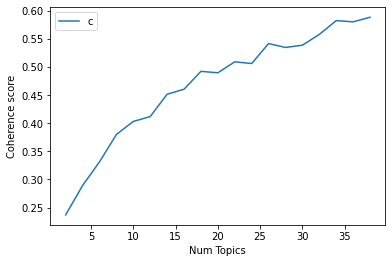

In [32]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2369
Num Topics = 4  has Coherence Value of 0.2891
Num Topics = 6  has Coherence Value of 0.3311
Num Topics = 8  has Coherence Value of 0.3798
Num Topics = 10  has Coherence Value of 0.403
Num Topics = 12  has Coherence Value of 0.4116
Num Topics = 14  has Coherence Value of 0.4513
Num Topics = 16  has Coherence Value of 0.4602
Num Topics = 18  has Coherence Value of 0.492
Num Topics = 20  has Coherence Value of 0.4894
Num Topics = 22  has Coherence Value of 0.5089
Num Topics = 24  has Coherence Value of 0.5059
Num Topics = 26  has Coherence Value of 0.5413
Num Topics = 28  has Coherence Value of 0.5345
Num Topics = 30  has Coherence Value of 0.5385
Num Topics = 32  has Coherence Value of 0.5577
Num Topics = 34  has Coherence Value of 0.5822
Num Topics = 36  has Coherence Value of 0.58
Num Topics = 38  has Coherence Value of 0.5882


In [34]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(10,
  '0.131*"good" + 0.090*"create" + 0.084*"build" + 0.063*"job" + '
  '0.060*"opportunity" + 0.027*"late" + 0.027*"act" + 0.027*"step" + '
  '0.024*"happen" + 0.024*"expand"'),
 (20,
  '0.175*"vaccine" + 0.117*"covid" + 0.076*"critical" + 0.076*"tool" + '
  '0.055*"develop" + 0.052*"amp" + 0.047*"government" + 0.029*"deliver" + '
  '0.026*"protect" + 0.026*"funding"'),
 (6,
  '0.178*"great" + 0.118*"talk" + 0.094*"investment" + 0.076*"conversation" + '
  '0.039*"role" + 0.039*"program" + 0.027*"project" + 0.027*"area" + '
  '0.024*"sit" + 0.021*"recent"'),
 (5,
  '0.132*"learn" + 0.102*"world" + 0.093*"thing" + 0.045*"scientist" + '
  '0.033*"variant" + 0.030*"understand" + 0.027*"video" + 0.024*"event" + '
  '0.021*"omicron" + 0.021*"thrill"'),
 (9,
  '0.203*"pandemic" + 0.113*"end" + 0.102*"prevent" + 0.049*"covid" + '
  '0.047*"bad" + 0.023*"lesson" + 0.015*"prepare" + 0.015*"success" + '
  '0.015*"home" + 0.012*"point"'),
 (29,
  '0.138*"energy" + 0.087*"technology" + 0.080*"i

Topic summarization
Topic 0 - About the attitude required to succeed.

Topic 1 - Inspirational talk and their role plays.

Topic 2 - About when feeling loved and excited.

Topic 6 - About vaccinations and its effects.

Topic 7 - Specifing a particular event in an year.

Topic 8 - About the future and advancements that can take place.

Topic 9 - Schools, teachers and organizations.

Topic 12 - About scientists and their impressive works and achievements.

Topic 13 - Questions and answers about different topics through out history.

Topic 16 - About different countries and their commitments.

Topic 17 - About work.

Topic 18 - ABout life.

Topic 20 - About poverty.

Topic 21 - Critical health needs and their progress.

Topic 22 - About Infrastructures and Innovations.

Topic 23 - About education and learning.

Topic 24 - Technology and its innovations.

Topic 25 - About farmers and their hope.

Topic 26 - About the pandemic.

Topic 28 - About global health.

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [35]:
# Write your code here

from gensim.models import LsiModel
LSAModel = LsiModel(corpus, 20, id2word)




In [36]:
# defining compute for Coherence Values in LSI
def computeCoherenceValuesLSI(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    modelList = []
#providning start,stop and step
    for num_topics in range(start, stop, step):
        # generate LSA model
        LSAModel = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        modelList.append(LSAModel)
        coherencemodel = CoherenceModel(model=LSAModel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return modelList, coherence_values

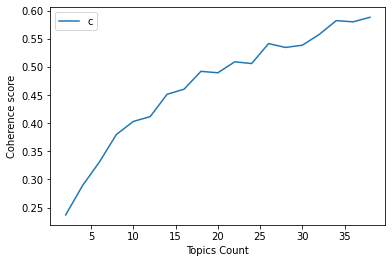

In [37]:
# taking all the values from above and plotting a graph
start,stop,step=2,40,2
modelListLSA, coherenceValuesLSA = computeCoherenceValuesLSI(id2word, corpus,data_lemmatized,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
# giving labels to axis
plt.xlabel("Topics Count")
plt.ylabel("Coherence score")
plt.legend(("conValues"), loc='best')
plt.show()

In [38]:
# To get the topics count and the coherence values

for numberOfTopics, cv in zip(range(2, 40, 2), coherenceValuesLSA):
  print("Topics Count:", numberOfTopics, " - Coherence Value:", round(cv, 4))
#pprint(LSAModel.print_topics())

Topics Count: 2  - Coherence Value: 0.251
Topics Count: 4  - Coherence Value: 0.2278
Topics Count: 6  - Coherence Value: 0.2304
Topics Count: 8  - Coherence Value: 0.2367
Topics Count: 10  - Coherence Value: 0.2348
Topics Count: 12  - Coherence Value: 0.231
Topics Count: 14  - Coherence Value: 0.2365
Topics Count: 16  - Coherence Value: 0.2542
Topics Count: 18  - Coherence Value: 0.2527
Topics Count: 20  - Coherence Value: 0.2511
Topics Count: 22  - Coherence Value: 0.2521
Topics Count: 24  - Coherence Value: 0.2505
Topics Count: 26  - Coherence Value: 0.2298
Topics Count: 28  - Coherence Value: 0.244
Topics Count: 30  - Coherence Value: 0.251
Topics Count: 32  - Coherence Value: 0.2478
Topics Count: 34  - Coherence Value: 0.2358
Topics Count: 36  - Coherence Value: 0.2694
Topics Count: 38  - Coherence Value: 0.2353


In [39]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [40]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [41]:
# LSA Model
number_of_topics=14
words=10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)
pprint(model.print_topics())

[(0, '0.406*"world" + 0.263*"work" + 0.261*"make" + 0.213*"help" + 0.188*"year" + 0.187*"need" + 0.181*"people" + 0.169*"health" + 0.139*"climate_change" + 0.138*"country"'), (1, '-0.556*"year" + 0.400*"world" + 0.242*"need" + 0.228*"climate_change" + -0.185*"health" + 0.156*"energy" + -0.156*"country" + -0.133*"life" + 0.126*"innovation" + 0.120*"avoid"'), (2, '-0.350*"health" + 0.338*"year" + -0.297*"world" + 0.254*"energy" + 0.227*"new" + -0.204*"country" + 0.203*"book" + 0.201*"climate_change" + -0.193*"help" + 0.192*"make"'), (3, '0.567*"world" + -0.282*"help" + -0.252*"need" + -0.239*"country" + 0.232*"work" + 0.230*"year" + -0.202*"health" + -0.160*"energy" + -0.149*"vaccine" + -0.148*"new"'), (4, '0.638*"work" + -0.282*"help" + -0.279*"people" + 0.243*"health" + -0.185*"book" + -0.183*"world" + 0.160*"energy" + 0.108*"thank" + -0.101*"well" + -0.099*"year"'), (5, '-0.665*"make" + 0.292*"work" + 0.237*"people" + -0.223*"progress" + 0.184*"life" + 0.182*"climate_change" + 0.180*"

SUMMARIZATION OF LSA TOPICS

Topic 0 - About advancing the world and different countries improving its people progress.

Topic 1 - About different advancements every year.

Topic 2 - About countries and its people making world healthy and happy place to survive.

Topic 3 - About the world needing new ideologies to stop the pandemic.

Topic 4 - About how working people can help the world.

Topic 5 - About countries worrying about its people and employees health.

Topic 6 - About people staying safe during the crisis.

Topic 7 - About spreding the ideology of getting vaccinated.

Topic 8 - About vacinnations and how it helps peoples health.

Topic 9 - About the progress of the pandemic.

Topic 10 - About the pandemic and on how to fight through it.

Topic 11 - About books and their stories.

Topic 12 - About vacinnations to fight covid 19.

Topic 13 - About fighting for advancements in energy and its progress.

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here





## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [47]:
# Write your code here

%%capture
!pip install bertopic



In [50]:
import pandas as pd
data = pd.read_csv("Tweets.csv")
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

data["Text"] = data["Text"].apply(cleantext)

#Converting the text into lower case
data['Text']=data["Text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

#removing stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words('english')
data['Text']=data['Text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))


#Lemmatization
from textblob import Word
nltk.download('wordnet')
#data['Text']=data['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Convert to list
docs = data.Text.values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2022-11-07 03:24:51,219 - BERTopic - Transformed documents to Embeddings
2022-11-07 03:25:06,361 - BERTopic - Reduced dimensionality
2022-11-07 03:25:06,483 - BERTopic - Clustered reduced embeddings


In [52]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,206,-1_health_world_work_new
1,0,190,0_climate_change_energy_zero
2,1,165,1_pandemic_covid_vaccines_vaccine
3,2,48,2_students_school_teachers_teacher
4,3,44,3_malaria_tb_mosquito_mosquitoes


In [53]:
topic_model.get_topic(0)  # Select the most frequent topic

[('climate', 0.07887972448464017),
 ('change', 0.055376561327799355),
 ('energy', 0.04665285257562094),
 ('zero', 0.03997534803947817),
 ('disaster', 0.03675537274231476),
 ('emissions', 0.033751955697094105),
 ('avoid', 0.031340410053772146),
 ('need', 0.031044713239490297),
 ('net', 0.03017990924340944),
 ('clean', 0.028223056673287714)]

In [54]:
topic_model.visualize_topics()

In [55]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [56]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [57]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
#topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [59]:
topic_model.visualize_term_rank()

In [61]:
#topic_model.update_topics(docs, topics, n_gram_range=(1, 2))

In [62]:
topic_model.get_topic(0)   # We select topic that we viewed before

[('climate', 0.053258114262132734),
 ('climate change', 0.03665888623104325),
 ('change', 0.036151988185799955),
 ('energy', 0.029284783265668475),
 ('zero', 0.024728894590682966),
 ('disaster', 0.022504795499723895),
 ('climate disaster', 0.02206906546041765),
 ('emissions', 0.020579663125996014),
 ('need', 0.019898151924022337),
 ('avoid', 0.019053823527316376)]

In [ ]:
#new_topics, new_probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=20)

In [64]:
similar_topics, similarity = topic_model.find_topics("energy", top_n=5); similar_topics


[0, -1, 12, 8, 13]

In [65]:
topic_model.get_topic(2)

[('students', 0.06403360458261806),
 ('school', 0.04708325986557052),
 ('teachers', 0.04182867189291093),
 ('teacher', 0.03508513198687343),
 ('high school', 0.02926506727101092),
 ('year', 0.027298984002456037),
 ('teacher year', 0.027178089775467845),
 ('high', 0.0268898605025856),
 ('state', 0.023242726778622515),
 ('kids', 0.02276171898856405)]

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)



Since topic models cannot ensure that their output is comprehensible, they can be evaluated using the concept of topic coherence. 
We can distinguish the signal (the main subjects) in our data by using topic modeling to filter out the noise and handle the large dimensionality of text data.

There are various Topic Modeling techniques; the two that are most frequently used are Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).

The best and most popular method for defining and using topic modeling is LDA, or Latent Dirichlet Allocation. From statistical data, topic probabilities are extracted.

Latent Dirichlet Allocation :

LDA is a topic modeling method that is widely used to extract themes from textual input. Topic models automatically and unsupervised learn themes from unlabeled documents, which are often described as clusters of key terms. Since there is no guarantee that a subject will be easy to interpret, coherence criteria have been devised to separate good themes from bad ones. We created the necessary corpora and dictionaries for topic modeling. The corpus and dictionary serve as the LDA topic model's two primary inputs. Gensim has given each word in the document a distinct id. The number of subjects must be disclosed in addition to the corpus and dictionary. Since LDA is an unsupervised method, we are unsure of the number of topics in our corpus prior to running the model.We may use the LDA visualization tool pyLDAvis to test a limited set of themes and compare the outcomes. Topic coherence is one of the methods most frequently used to calculate the number of themes. To determine which LDA model has the highest coherence value, we must generate several of them with varying amounts of topics (k). The relationship between coherence value and number of subjects shows a reduction in coherence score of 30 as the number of topics rises. The number of topics picked is still determined by the requirements because topics with a coherence score of roughly 30 have strong coherence scores but may contain repeating keywords in the topic.Consequently, the observation coherence score for the data generated by the LDA approach is 0.58.

Latent Semantic Analysis :

The Bag of Words (BoW) model, used by the LSA, is backed by data from a term-document matrix (occurrence of terms in a document). By performing a matrix decomposition on the document-term matrix, LSA uses singular value decomposition to identify latent themes. The most effective method for analyzing and interpreting k (number of topics) in topic modeling is the Topic Coherence Measure, which offers a realistic measure for detecting the number of topics.The computation uses the average/median pairwise word similar scores of the terms in a topic. It has a high value to use the topic coherence score model. The coherence score decreases as the number of topics rises, as shown by the coherence value vs. number of subjects plot. The 14 subjects that have the highest coherence scores decide the coherence value that was achieved for the data using the LDA algorithm, which is 0.25.

BerTopic:

BerTopic is a topic modeling method that produces dense clusters using transformers (BERT embeddings) and class-based TF-IDF. Additionally, it enables you to quickly evaluate and display the subjects produced.

In light of the aforementioned analysis, I can therefore say that LDA (Latent Dirichlet Allocation) works best with a topic size of 30. However, given that BerTopic is a more recent model and has the most vocabulary of any model, it is probably preferable.